# Evaluation of multi-omics GRN inference methods
## Benchmarking of the inferred GRNs
### by Jalil Nourisa



# Imports

In [1]:
# !pip install anndata lightgbm

In [2]:
# !conda install -c conda-forge graph-tool -y 

In [1]:
import os
import gzip
import pandas as pd
import numpy as np
import anndata as ad
from sklearn.model_selection import LeaveOneOut, StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split, LeaveOneGroupOut, KFold
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tqdm
import scipy
import json
# import category_encoders as ce
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.multioutput import MultiOutputRegressor
from scipy.sparse import csr_matrix
import lightgbm
from local_utils import plots

%matplotlib inline

work_dir = '../output'
resource_dir = '../resources'
os.makedirs(f'{work_dir}', exist_ok=True)

In [2]:
methods = ['Random',
 'CollectRI',
 'FigR',
 'CellOracle',
 'GRaNIE',
 'ANANSE',
 'scGLUE',
 'Scenic+',
 'HKG',
 'Positive',
 'Negative',
 'Positive Control',
 'Negative Control']

surragate_names = {'CollectRI': 'CollectRI', 'collectRI':'CollectRI', 'collectRI_sign':'CollectRI-signs',
                   'Scenic+': 'Scenic+', 'scenicplus':'Scenic+', 'scenicplus_sign': 'Scenic+-signs',
                   'CellOracle': 'CellOracle', 'celloracle':'CellOracle', 'celloracle_sign':'CellOracle-signs',
                   'figr':'FigR', 'figr_sign':'FigR-signs',
                   'baseline':'Baseline',
                   'cov_net': 'Pearson cov',
                   'granie':'GRaNIE',
                   'ananse':'ANANSE',
                   'scglue':'scGLUE',
                   
                   'positive_control':'Positive Control',
                   'negative_control':'Negative Control',
                   'pearson':'Pearson',
                   'SL':'SLA'
                   }

# COLORS = {
#     'Random': '#74ab8c',
#     'CollectRI': '#83b17b',
#     'FigR': '#96b577',
#     'CellOracle': '#b0b595',
#     'GRaNIE': '#c9b4b1',
#     'ANANSE': '#e2b1cd',
#     'scGLUE': '#e5b8dc',
#     'Scenic+': '#dfc2e5',
#     'HKG': '#e7d2ec',
#     'Positive': 'darkblue',
#     'Negative': 'indianred',
#     'Positive Control': 'darkblue',
#     'Negative Control': 'indianred'
# }

COLORS = {
    'Random': '#74ab8c',
    'CollectRI': '#83b17b',
    'FigR': '#56B4E9',
    'CellOracle': '#b0b595',
    'GRaNIE': '#009E73',
    'ANANSE': '#e2b1cd',
    'scGLUE': '#D55E00',
    'Scenic+': '#dfc2e5',
    'HKGs': 'darkblue',
    'Positive': 'darkblue',
    'Negative': 'indianred',
    'Positive Control': 'darkblue',
    'Negative Control': 'indianred'
}
LINESTYLES = {
    'Random': '-',
    'CollectRI': '--',
    'FigR': '-.',
    'CellOracle': ':',
    'GRaNIE': ':',
    'ANANSE': '--',
    'scGLUE': '-.',
    'Scenic+': '-',
}

In [3]:
controls3 = ['Dabrafenib', 'Belinostat', 'Dimethyl Sulfoxide']
control_compound = 'Dimethyl Sulfoxide'


def shuffle_grn(grn):
    grn_s = grn.copy()
    grn_s['source'] = grn_s['source'].sample(frac=1).reset_index(drop=True)
    grn_s['target'] = grn_s['target'].sample(frac=1).reset_index(drop=True)
    dup_flags = grn_s[['source','target']].duplicated()
    grn_s = grn_s[~dup_flags].reset_index(drop=True)
    if grn_s.duplicated().sum()>0:
        raise ValueError('')
    return grn_s
def sign_grn(grn):
    grn_sign = grn.copy()
    weights = grn_sign.weight
    weights = [1 if weight>0 else -1 for weight in weights]
    grn_sign.weight = weights
    return grn_sign


# housekeeping genes
if False:
    df = pd.read_csv('https://www.tau.ac.il/~elieis/HKG/HK_genes.txt', sep=' ', header=None)

    housekeeping_genes = df.loc[:, 0]  # Gene names
    housekeeping_genes = df_train.columns[df_train.columns.isin(housekeeping_genes)].values
    np.savetxt(f'{work_dir}/benchmark/housekeeping_genes.txt', housekeeping_genes, fmt='%s')
else:
    housekeeping_genes = np.loadtxt(f'{work_dir}/benchmark/housekeeping_genes.txt', dtype=str)

print(f'Number of housekeeping genes: {len(housekeeping_genes)}')

if False:
    collectRI = pd.read_csv("https://github.com/pablormier/omnipath-static/raw/main/op/collectri-26.09.2023.zip")
    collectRI.to_csv(f'{work_dir}/collectri.csv')


Number of housekeeping genes: 3804


# Explanatory analysis 

In [18]:
grn_model_names = ['collectRI', 'figr', 'celloracle', 'granie', 'scglue', 'scenicplus']

n_nets = len(grn_model_names)

grn_models_dict = {}
for name in grn_model_names:
    grn_models_dict[name] = pd.read_csv(f'../output/benchmark/grn_models/{name}.csv', index_col=0)

grn_models_dict = {surragate_names[name]:grn for name, grn in grn_models_dict.items()}

In [19]:
peak_gene_model = ['figr', 'celloracle', 'granie']

grn_peak_gene_dict = {}
for name in peak_gene_model:
    model = pd.read_csv(f'../output/benchmark/peak_gene_models/{name}.csv', index_col=0)
    model.peak = model.source.str.replace('_','-')
    model.peak = model.source.str.replace(':','-')
    grn_peak_gene_dict[name] = model
grn_peak_gene_dict = {surragate_names[name]:grn for name, grn in grn_peak_gene_dict.items()}

/tmp/ipykernel_188100/1062260597.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  model.peak = model.source.str.replace('_','-')
/tmp/ipykernel_188100/1062260597.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  model.peak = model.source.str.replace('_','-')
/tmp/ipykernel_188100/1062260597.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  model.peak = model.source.str.replace('_','-')


## Data structure 

In [695]:
from local_utils import network, plots, annotation

class Connectivity:
    def __init__(self, net, **kwargs):
        self.out_deg = network.degree_centrality(net, source='source', target='target',  **kwargs)
        self.in_deg = network.degree_centrality(net, source='target', target='source',  **kwargs)
def calculate_hvgs_stats(geneset):
    hvgs = np.loadtxt( f'{resource_dir}/benchmark/hvgs.txt', dtype=str)
    pert_genes = np.loadtxt(f'{work_dir}/benchmark/perturb_gene_names.txt', dtype=str)
    
    n_random = 1000
    
    shared_genes = np.intersect1d(geneset, pert_genes)
    shared_hvgs_n = len(np.intersect1d(hvgs, shared_genes))
    shared_hvgs_ratio = shared_hvgs_n/len(shared_genes)

    # to percentile
    random_ratios = []
    for i in range(n_random):
        random_genes = np.random.choice(pert_genes, shared_hvgs_n)
        random_ratios.append(len(np.intersect1d(hvgs, random_genes))/shared_hvgs_n)
    top_p = ((np.asarray(random_ratios)>shared_hvgs_ratio).sum()/n_random)*100


    return {'n_included_hvgs':shared_hvgs_n, 'ratio':shared_hvgs_ratio, 'percentile_rank':round(top_p,1)} 
class Explanatory_analysis:
    '''
    This class provides functions for explanatory analysis of GRNs including topology analysis and biological annotaions.
    '''
    def __init__(self, net, peak_gene_net=None):
        self.net = net 
        self.peak_gene_net = peak_gene_net
        #TODO: check the format. [source, target, weight]

        self.tfs = net.source.unique()
        self.targets = net.target.unique()
        if peak_gene_net is not None:
            self.cres = peak_gene_net.source.unique()
        # check duplicates
        dup_flag = False
        if 'cell_type' in net.columns:
            if net.duplicated(subset=['source','target','cell_type']).any():
                dup_flag = True
        else:
            if net.duplicated(subset=['source','target']).any():
                dup_flag = True
        if dup_flag:
            raise ValueError('The network has duplicated source target combinations.')
        self.peak_annot = None
        self.hvg_stats = None

        self.calculate_basic_stats()

    def calculate_all(self):
        '''Calculate all metrics 
        '''
        self.calculate_basic_stats()
        self.calculate_centrality_stats()
        self.annotate_peaks()
        self.calculate_hvgs_stats()
    def calculate_basic_stats(self):
        self.n_links = self.net.shape[0]
        self.n_source = self.net.source.nunique()
        self.n_target = self.net.target.nunique()
        self.ratio_positive_negative =  (self.net.weight>=0).sum()/(self.net.shape[0])
    def calculate_centrality_stats(self) -> None:
        '''Calculate network centrality metrics such as in and out degree
        '''
        self.tf_gene = Connectivity(self.net, normalize=True)
        if self.peak_gene_net is None:
            self.peak_gene = None
            self.n_cres = None
        else:
            self.peak_gene = Connectivity(self.peak_gene_net, normalize=False)
            self.n_cres = self.peak_gene_net.source.nunique()
    def plot_cdf(self, values, ax=None, title=''):
        plots.plot_cumulative_density(values, ax=ax, title=title)
    def plot_connectivity(self):
        data_list = [self.tf_gene.out_deg, self.tf_gene.in_deg]
        if self.peak_gene is not None:
            data_list += [self.peak_gene.in_deg]
        for data in data_list:
            plots.plot_cumulative_density(data)
    def calculate_hvgs_stats(self) -> dict[str, float]:
        ''' Calculates metrics related to the inclusion of HVGs in the network.
        '''
        self.hvg_stats = calculate_hvgs_stats(self.targets)
        return self.hvg_stats
    def annotate_peaks(self) -> dict[str, float]:
        '''Annotate peaks with associated regions on genome.
        '''
        peaks = self.format_peak(self.cres)
        annotation_df = pd.read_csv(f'{resource_dir}/benchmark/peak_annotation.csv')
        annotation_df = annotation_df[annotation_df.peak.isin(peaks)]
        value_counts = annotation_df.annotation.value_counts()
        sum_values = value_counts.sum()
        value_ratio = ((value_counts/sum_values)*100).round(1)

        self.peak_annot = value_ratio.to_dict()
        return self.peak_annot
    @staticmethod
    def format_peak(peaks:list[str]) -> list[str]:
        '''Convert any peak data to chr:start-end
        '''
        import re
        formatted_peaks = []
        for peak in peaks:
            chr_, start, end = re.split(r'[:\-_]', peak)
            peak = f"{chr_}:{start}-{end}"

            formatted_peaks.append(peak)
        return formatted_peaks
    def annotate_genes(self) -> dict[str, float]:
        '''Annotates genes'''
        multiomics_genes = np.loadtxt(f'{work_dir}/benchmark/multiomics_genes.txt', dtype=str)
        gene_annotation_df = pd.read_csv(f'{work_dir}/benchmark/gene_annotation.csv')
        shared_genes = np.intersect1d(self.targets, multiomics_genes)
        gene_annot = gene_annotation_df[gene_annotation_df.Gene.isin(shared_genes)].Transcript_type.value_counts().to_dict()
        # gene_annot.values
        self.gene_annot = {key:round((value*100/len(shared_genes)), 1) for key, value in gene_annot.items()}
        return self.gene_annot
    
   
info_objs_dict = {}
for name in grn_models_dict.keys():
    print(name)
    net = grn_models_dict[name]
    net_peak_gene = grn_peak_gene_dict.get(name, None)

    info_obj = Explanatory_analysis(net=net, peak_gene_net=net_peak_gene)

    info_objs_dict[name] = info_obj

    print(info_objs_dict[name].annotate_genes())

CollectRI
{'Protein coding': 99.7, 'LncRNA': 0.1}
FigR
{'Protein coding': 92.9, 'LncRNA': 6.4}
CellOracle
{'Protein coding': 96.1, 'LncRNA': 3.3}
GRaNIE
{'Protein coding': 99.8, 'LncRNA': 0.0}
scGLUE
{'Protein coding': 87.5, 'LncRNA': 11.3}
Scenic+
{'Protein coding': 99.3, 'LncRNA': 0.0}


## Topological analysis

### General stats

In [658]:
# regulatory links
links_n = {}
for name, grn in grn_models_dict.items():
    if 'cell_type' in grn.columns: # for cell specific grn models, take the mean
        n_grn = grn.groupby('cell_type').size().mean()
    else:
        n_grn = len(grn)
    links_n[name] = n_grn
print(links_n)

# positive vs negative
regulatory_effect_dict = {}
for name, grn in grn_models_dict.items():
    print('-----', name)
    grn_sign = grn.copy()
    weights = grn_sign.weight
    weights = [1 if weight>0 else -1 for weight in weights]
    grn_sign.weight = weights
    if 'cell_type' in grn.columns:
        celltype_counts = grn_sign.groupby('cell_type').weight.value_counts()
        signs = [celltype_counts[celltype_counts.index.get_level_values('weight')==1].mean(), celltype_counts[celltype_counts.index.get_level_values('weight')==-1].mean()]
    else:
        signs = grn_sign.weight.value_counts().values # 'positive, negative:
    if len(signs)==1:
        signs = [signs[0], 0]
    regulatory_effect_dict[name] = signs
regulatory_effect_dict
# tfs and targets
target_genes_dict = {}
tfs_dict = {}
for name, grn in grn_models_dict.items():
    grn = grn[grn.target.isin(multiomics_genes)]
    tfs_dict[name] = grn.source.unique() 
    target_genes_dict[name] = grn.target.unique().tolist()


print('number of TFs')
tfs_dict_n =  {key:len(values) for key,values in tfs_dict.items()}
print(tfs_dict_n)
print('number of targets')
target_genes_dict_n = {key:len(values) for key,values in target_genes_dict.items()}
target_genes_dict_n

# peaks
peaks_dict = {}
peaks_n_dict = {}
for name, df in grn_peak_gene_dict.items():
    peaks_dict[name] = df.source.unique()
    peaks_n_dict[name] = df.source.nunique()

{'CollectRI': 43178, 'FigR': 24292, 'CellOracle': 54693.0, 'GRaNIE': 10679, 'scGLUE': 51567, 'Scenic+': 33537}
----- CollectRI
----- FigR
----- CellOracle
----- GRaNIE
----- scGLUE
----- Scenic+
number of TFs
{'CollectRI': 1133, 'FigR': 389, 'CellOracle': 557, 'GRaNIE': 180, 'scGLUE': 439, 'Scenic+': 139}
number of targets


#### Plot

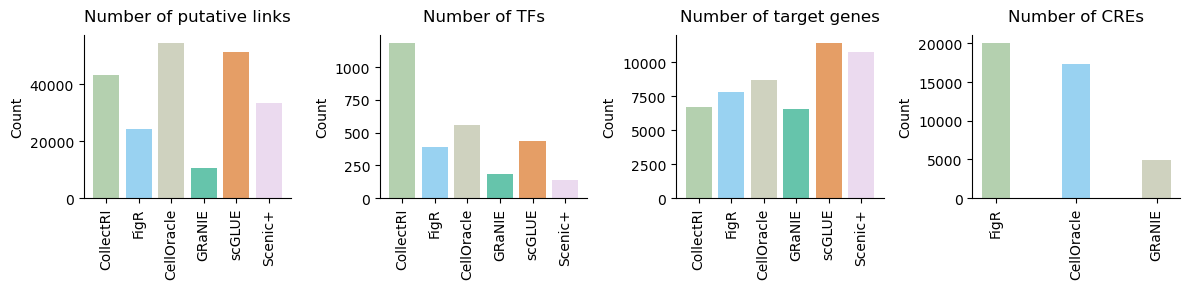

In [393]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3)) 
color = 'grey'
## number of links
ax = axes[0]
colors = [COLORS[name] for name in links_n.keys()]
ax.bar(links_n.keys(), links_n.values(), color=colors,  alpha=.6)
# ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Number of putative links', pad=10)
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
# ax.set_yscale('log')

# Rotate category names for better readability
plt.xticks(rotation=45)
## number of TFs
ax = axes[1]
ax.bar(tfs_dict_n.keys(), tfs_dict_n.values(), color=colors,  alpha=.6)
# ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Number of TFs', pad=10)
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
# ax.set_yscale('log')
## number of target 
ax = axes[2]

ax.bar(target_genes_dict_n.keys(), target_genes_dict_n.values(), color=colors,  alpha=.6)
# ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Number of target genes', pad=10)
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
# ax.set_yscale('log')
plt.tight_layout()

## number of peaks 
ax = axes[3]
colors = [COLORS[name] for name in links_n.keys()]
ax.bar(peaks_n_dict.keys(), peaks_n_dict.values(), color=colors, width=0.35, alpha=.6)
# ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Number of CREs', pad=10)
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
# ax.set_yscale('log')
plt.tight_layout()

fig.savefig(f'{work_dir}/benchmark/figs/stats_regulatory_elements.png', dpi=150, transparent=True)

#### Regulatory signs

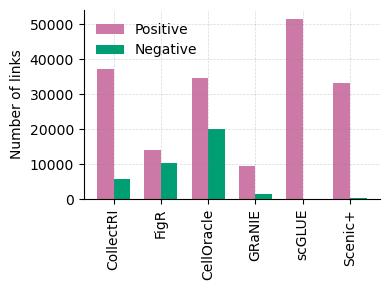

In [690]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3)) 
# regulatory role 
data = regulatory_effect_dict
categories = list(data.keys())
positive_counts = [data[category][0] for category in categories]
negative_counts = [data[category][1] for category in categories]
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
bars1 = ax.bar(x - width/2, positive_counts, width, label='Positive', color=plots.colors_blind[6])
bars2 = ax.bar(x + width/2, negative_counts, width, label='Negative', color=plots.colors_blind[2])
ax.set_ylabel('Number of links')
# ax.set_title('Regulatory sign')
ax.set_xticks(x)
# ax.set_scale('log')
ax.set_xticklabels(categories)
# ax.set_xticklabels([category for category in categories])
ax.tick_params(axis='x', rotation=90)
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
ax.grid(alpha=0.3, linestyle='--', linewidth=.5, color='grey')
# ax.set_yscale('log')
ax.legend(frameon=False)
plt.tight_layout()
fig.savefig(f'{work_dir}/benchmark/figs/regulatory_signs.png', dpi=300, transparent=True)

### Connectivity

#### Centrality

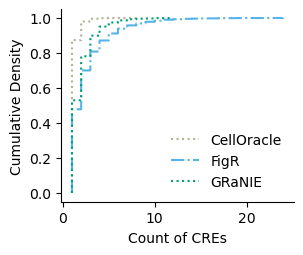

In [388]:
# peak gene: in degree
def plot_cumulative_density(data, title='', x_label='Number of CREs', ax=None, s=1, **kwdgs):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

    ax.step(sorted_data, cdf, where='post', label=title, **kwdgs)

    ax.set_xlabel(x_label)
    ax.set_ylabel('Cumulative Density')
    ax.spines[['top','right']].set_visible(False)
    # ax.grid(True)
    return fig, ax

fig, ax = plt.subplots(figsize=(3, 2.5))
for i_plot, name in enumerate(['CellOracle','FigR','GRaNIE']):
    info_objs_dict[name].calculate_centrality_stats()
    values = info_objs_dict[name].peak_gene.in_deg
    plot_cumulative_density(values, title=name, x_label='Count of CREs', ax=ax, linestyle=LINESTYLES[name], c=COLORS[name])
ax.legend(frameon=False)
# ax.set_title('In-degree centrality: CRE-gene', pad=20)

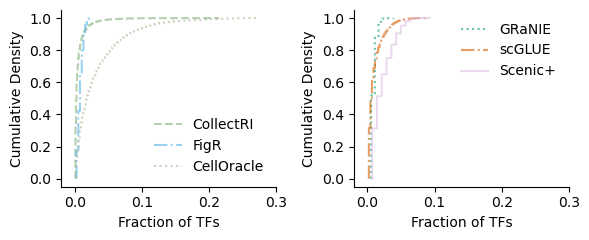

In [387]:
# tf gene: in degree
fig, axes = plt.subplots(1, 2, figsize=(6, 2.5))
for i_plot, name in enumerate(grn_models_dict.keys()):
    info_objs_dict[name].calculate_centrality_stats()
    values = info_objs_dict[name].tf_gene.in_deg

    if i_plot < 3:
        ax = axes[0]
    else:
        
        ax = axes[1]
    plot_cumulative_density(values, title=name,x_label='Fraction of TFs', ax=ax, linestyle=LINESTYLES[name], c=COLORS[name], alpha=.6)
    ax.legend(frameon=False)
    ax.set_xlim([-.02,.3])
    # ax.set_title('(a) In-degree centrality: TF-gene', pad=20)
plt.tight_layout()

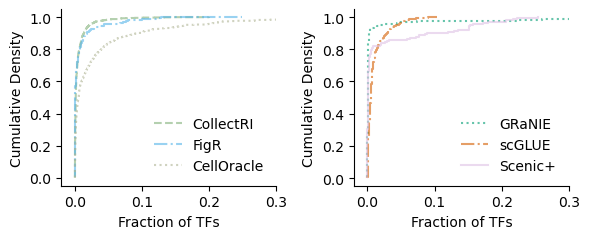

In [389]:
# tf gene: out degree 
fig, axes = plt.subplots(1, 2, figsize=(6, 2.5))
for i_plot, name in enumerate(grn_models_dict.keys()):
    info_objs_dict[name].calculate_centrality_stats()
    values = info_objs_dict[name].tf_gene.out_deg

    if i_plot < 3:
        ax = axes[0]
    else:
        
        ax = axes[1]
    plot_cumulative_density(values, title=name,x_label='Fraction of TFs', ax=ax, linestyle=LINESTYLES[name], c=COLORS[name], alpha=.6)
    ax.legend(frameon=False)
    ax.set_xlim([-.02,.3])
    # ax.set_title('(a) In-degree centrality: TF-gene', pad=20)
plt.tight_layout()

### Intersection of GRN elements

In [633]:
# Create a set of all unique genes
def normalize_formatize_interactions(data_dict):
    all_cases = list(set(item for items in data_dict.values() for item in items))
    
    # Initialize DataFrame
    df = pd.DataFrame(index=all_cases)
    # Populate DataFrame
    for key, items in data_dict.items():
        df[key] = df.index.isin(items)
    return df

In [651]:
multiomics_genes = np.loadtxt(f'{work_dir}/benchmark/multiomics_genes.txt', dtype=str)
grn_fused_dict = {}
for name, grn in grn_models_dict.items():
    
    grn = grn[grn.target.isin(multiomics_genes)]
    grn['link'] = grn['source'] + '_' + grn['target']
    grn_fused_dict[name] = grn['link'].drop_duplicates().reset_index(drop=True)

/tmp/ipykernel_188100/485285719.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grn['link'] = grn['source'] + '_' + grn['target']


In [574]:
del target_genes_dict['CollectRI']
del grn_fused_dict['CollectRI']
del tfs_dict['CollectRI']

KeyError: 'CollectRI'

In [642]:
(normalize_formatize_interactions(grn_fused_dict).sum(axis=1)==(len(grn_fused_dict))).sum()

1

 ####### links
['CellOracle', 'scGLUE', 'Scenic+', 'CollectRI', 'FigR', 'GRaNIE']


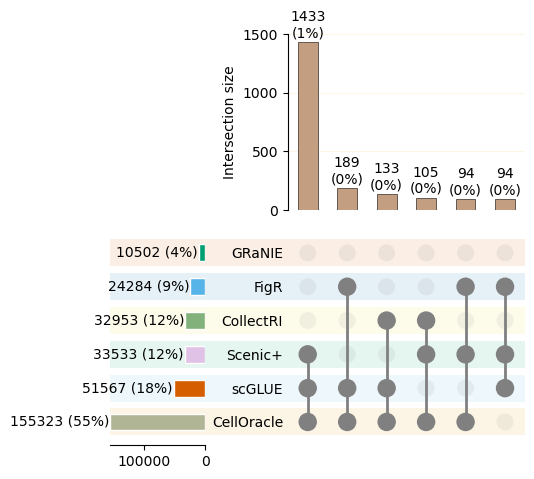

In [668]:
import upsetplot

print(' ####### links')
fig = plt.figure()
df_interactions = normalize_formatize_interactions(grn_fused_dict)
out_dict = upsetplot.plot(upsetplot.from_indicators(indicators=lambda a: a==True, data=df_interactions), fig=fig, 
        show_counts=True, 
        show_percentages = '{:.0%}',
        sort_by='cardinality', 
        # min_subset_size =".1%", # min interaction to show
        min_subset_size = 70, # min interaction to show
        min_degree=3,
        facecolor='grey',
        other_dots_color=.1, 
        shading_color =.01, 
        with_lines = True,
        element_size = 35,
        intersection_plot_elements=5,
        totals_plot_elements = 2
        )
# Loop through each bar and change its face color


matrix_ax, shading_ax, totals_ax, intersections_ax = out_dict['matrix'], out_dict['shading'], out_dict['totals'], out_dict['intersections']

methods_order = [label.get_text() for label in matrix_ax.get_yticklabels()]
# methods_order.reverse()
print(methods_order)
for i_bar, bar in enumerate(totals_ax.patches):
    bar.set_facecolor(COLORS[methods_order[i_bar]])
    bar.set_edgecolor('white')

for bar in intersections_ax.patches:
    bar.set_facecolor(plots.colors_cell_type[2])
    bar.set_edgecolor('black')
    bar.set_linewidth(.4)

for bar, new_color in zip(shading_ax.patches, plots.colors_blind):
    bar.set_facecolor(new_color)
    bar.set_alpha(.1)
    bar.set_edgecolor('black')

plt.subplots_adjust(wspace=-.4)  # Example adjustment, modify as needed


fig.savefig(f'{work_dir}/benchmark/figs/links_interactions.png', dpi=300, transparent=True,  bbox_inches='tight')
# plt.show()

 ####### TFs
['CollectRI', 'CellOracle', 'scGLUE', 'FigR', 'GRaNIE', 'Scenic+']


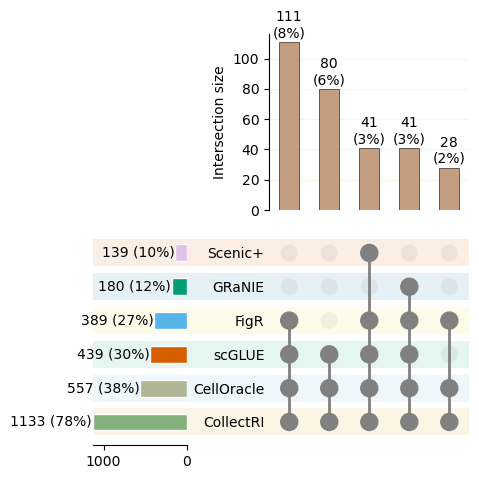

In [669]:
print(' ####### TFs')
fig = plt.figure()
df_interactions = normalize_formatize_interactions(tfs_dict)
out_dict = upsetplot.plot(upsetplot.from_indicators(indicators=lambda a: a==True, data=df_interactions), fig=fig, 
        show_counts=True, 
        show_percentages = '{:.0%}',
        sort_by='cardinality', 
        min_subset_size =22, # min interaction to show
        min_degree=3,
        facecolor='grey',
        other_dots_color=.1, 
        shading_color =.01, 
        with_lines = True,
        element_size = 35,
        intersection_plot_elements=5,
        totals_plot_elements = 2
        )
# Loop through each bar and change its face color


matrix_ax, shading_ax, totals_ax, intersections_ax = out_dict['matrix'], out_dict['shading'], out_dict['totals'], out_dict['intersections']
methods_order = [label.get_text() for label in matrix_ax.get_yticklabels()]
# methods_order.reverse()
print(methods_order)
for i_bar, bar in enumerate(totals_ax.patches):
    bar.set_facecolor(COLORS[methods_order[i_bar]])
    bar.set_edgecolor('white')

for bar in intersections_ax.patches:
    bar.set_facecolor(plots.colors_cell_type[2])
    bar.set_edgecolor('black')
    bar.set_linewidth(.4)

for bar, new_color in zip(shading_ax.patches, plots.colors_blind):
    bar.set_facecolor(new_color)
    bar.set_alpha(.1)
    bar.set_edgecolor('black')

plt.subplots_adjust(wspace=-.4)  # Example adjustment, modify as needed


fig.savefig(f'{work_dir}/benchmark/figs/TFs_interactions.png', dpi=300, transparent=True, bbox_inches='tight')
# plt.show()

 ####### target genes
['scGLUE', 'Scenic+', 'CellOracle', 'FigR', 'GRaNIE', 'CollectRI']


/tmp/ipykernel_188100/785144957.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


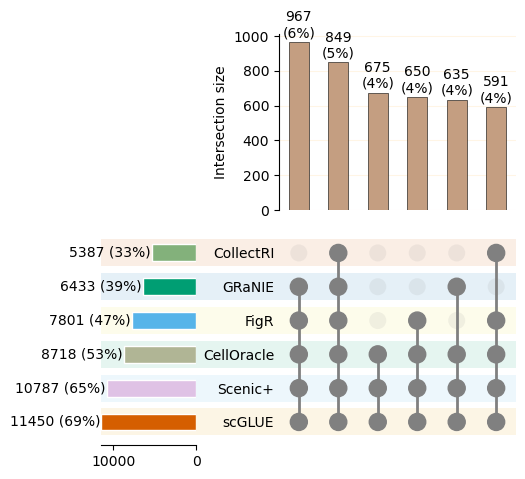

In [671]:

print(' ####### target genes')
fig = plt.figure(figsize=(4, 3.5))
df_interactions = normalize_formatize_interactions(target_genes_dict)
out_dict = upsetplot.plot(upsetplot.from_indicators(indicators=lambda a: a==True, data=df_interactions), fig=fig, 
        show_counts=True, 
        show_percentages = '{:.0%}',
        sort_by='cardinality', 
        min_subset_size = 500, # min interaction to show
        min_degree=3,
        facecolor=plots.colors_cell_type[4],
        other_dots_color=.1, 
        shading_color =.01, 
        with_lines = True,
        element_size = 35,
        intersection_plot_elements=5,
        totals_plot_elements = 2
        )
# Loop through each bar and change its face color


matrix_ax, shading_ax, totals_ax, intersections_ax = out_dict['matrix'], out_dict['shading'], out_dict['totals'], out_dict['intersections']
methods_order = [label.get_text() for label in matrix_ax.get_yticklabels()]
print(methods_order)
for i_bar, bar in enumerate(totals_ax.patches):
    bar.set_facecolor(COLORS[methods_order[i_bar]])
    bar.set_edgecolor('white')

for bar in intersections_ax.patches:
    bar.set_facecolor(plots.colors_cell_type[2])
    bar.set_edgecolor('black')
    bar.set_linewidth(.4)

for bar, new_color in zip(shading_ax.patches, plots.colors_blind):
    bar.set_facecolor(new_color)
    bar.set_alpha(.1)
    bar.set_edgecolor('black')

plt.subplots_adjust(wspace=-.4)  # Example adjustment, modify as needed
plt.tight_layout()

fig.savefig(f'{work_dir}/benchmark/figs/targets_interactions.png', dpi=300, transparent=True, bbox_inches='tight')

 ####### CREs
['FigR', 'CellOracle', 'GRaNIE']


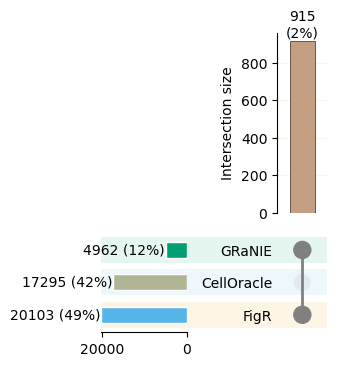

In [672]:
print(' ####### CREs')
fig = plt.figure(figsize=(4, 3.5))
df_interactions = normalize_formatize_interactions(peaks_dict)
out_dict = upsetplot.plot(upsetplot.from_indicators(indicators=lambda a: a==True, data=df_interactions), fig=fig, 
        show_counts=True, 
        show_percentages = '{:.0%}',
        sort_by='cardinality', 
        # min_subset_size = 500, # min interaction to show
        min_degree=2,
        facecolor=plots.colors_cell_type[4],
        other_dots_color=.1, 
        shading_color =.01, 
        with_lines = True,
        element_size = 35,
        intersection_plot_elements=5,
        totals_plot_elements = 2
        )

matrix_ax, shading_ax, totals_ax, intersections_ax = out_dict['matrix'], out_dict['shading'], out_dict['totals'], out_dict['intersections']
methods_order = [label.get_text() for label in matrix_ax.get_yticklabels()]
print(methods_order)
for i_bar, bar in enumerate(totals_ax.patches):
    bar.set_facecolor(COLORS[methods_order[i_bar]])
    bar.set_edgecolor('white')

for bar in intersections_ax.patches:
    bar.set_facecolor(plots.colors_cell_type[2])
    bar.set_edgecolor('black')
    bar.set_linewidth(.4)

for bar, new_color in zip(shading_ax.patches, plots.colors_blind):
    bar.set_facecolor(new_color)
    bar.set_alpha(.1)
    bar.set_edgecolor('black')

plt.subplots_adjust(wspace=-.3)  # Example adjustment, modify as needed


fig.savefig(f'{work_dir}/benchmark/figs/cres_interactions.png', dpi=300, transparent=True, bbox_inches='tight')

## Annoation

### Annotate peaks

#$## Check if all GRN peaks are in atac

In [60]:
adata_atac = ad.read_h5ad(f'{work_dir}/scATAC/adata_atac.h5ad')

/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [269]:
## check if all the peaks in grns given in atac data
import re

def format_peak(peaks):
    formatted_peaks = []
    for peak in peaks:
        chr_, start, end = re.split(r'[:\-_]', peak)
        peak = f"{chr_}:{start}-{end}"

        formatted_peaks.append(peak)
    return formatted_peaks


atac_peaks = format_peak(adata_atac.var_names)

# they should be all try
for name, grn_ct in grn_peak_gene_dict.items():
    grn_peaks = format_peak(grn_ct.source)
    print(name)
    assert np.in1d(grn_peaks, atac_peaks).all()

FigR
CellOracle
GRaNIE


#### Plot

In [270]:
annotation_dict = {}
for name in grn_peak_gene_dict.keys():
    annotation_dict[name] = info_objs_dict[name].annotate_peaks()
peak_annotation_df = pd.DataFrame.from_dict(annotation_dict, orient='index')
threshold = 1 # remove below this raction
peak_annotation_df = peak_annotation_df.loc[:, (peak_annotation_df>threshold).sum(axis=0)!=0]
peak_annotation_df

,Intron,Promoter,Distal Intergenic,Exon,3' UTR,Downstream (<=300)
FigR,37.0,31.0,18.6,6.6,4.5,1.6
CellOracle,0.6,98.5,0.3,0.2,0.1,0.0
GRaNIE,25.8,50.8,14.2,5.0,2.8,1.0


/tmp/ipykernel_188100/1265573703.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if counts[j] == 0:
/tmp/ipykernel_188100/1265573703.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if counts[j] > 1:
/tmp/ipykernel_188100/1265573703.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = f'{counts[j]:.1f} %'


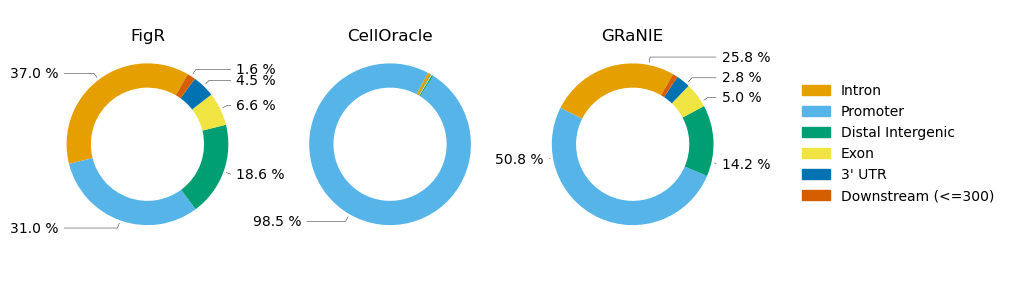

In [706]:
import matplotlib.patches as mpatches

fig, axes = plt.subplots(1, len(peak_annotation_df.index) + 1, figsize=(12, 3.5))

colors = plots.colors_blind
startangle = 60

theta_offsets = [2 , 2, 5]
for i, (ax, idx) in enumerate(zip(axes[:-1], peak_annotation_df.index)):
    ax.set_title(idx, fontsize=12, pad=0)
    counts = peak_annotation_df.loc[idx]
    wedges, texts = ax.pie(counts, colors=colors, wedgeprops=dict(width=0.3), startangle=startangle, radius=1)

    bbox_props = dict(fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-", linewidth=0.3), zorder=0, va="center", fontsize=10)

    for j, p in enumerate(wedges):
        if counts[j] == 0:
            continue
        ang = (p.theta2 - p.theta1) / theta_offsets[i] + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        if counts[j] > 1:
            text = f'{counts[j]:.1f} %'
            ax.annotate(text, xy=(x, y), xytext=(1.1 * np.sign(x), 1.1 * y),
                        horizontalalignment=horizontalalignment, **kw)

# Create a legend in the last subplot
ax = axes[-1]
patches = [mpatches.Patch(color=color, label=name) for color, name in zip(colors, peak_annotation_df.columns)]
leg = ax.legend(handles=patches, bbox_to_anchor=(1.15, 0.77), fontsize=10)
leg.get_frame().set_linewidth(0.0)
ax.axis('off')

# plt.tight_layout()
# plt.show()
fig.savefig(f'{work_dir}/benchmark/figs/peak_annotation.png', dpi=300, transparent=True, bbox_inches='tight')


### Annotate genes

In [697]:
annotation_dict = {}
for name in grn_models_dict.keys():
    annotation_dict[name] = info_objs_dict[name].annotate_genes()
gene_annotation_df = pd.DataFrame.from_dict(annotation_dict, orient='index')
gene_annotation_df

,Protein coding,LncRNA
CollectRI,99.7,0.1
FigR,92.9,6.4
CellOracle,96.1,3.3
GRaNIE,99.8,0.0
scGLUE,87.5,11.3
Scenic+,99.3,0.0


/tmp/ipykernel_188100/392224219.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if counts[j] == 0:
/tmp/ipykernel_188100/392224219.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if counts[j] > 1:
/tmp/ipykernel_188100/392224219.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = f'{counts[j]:.1f} %'


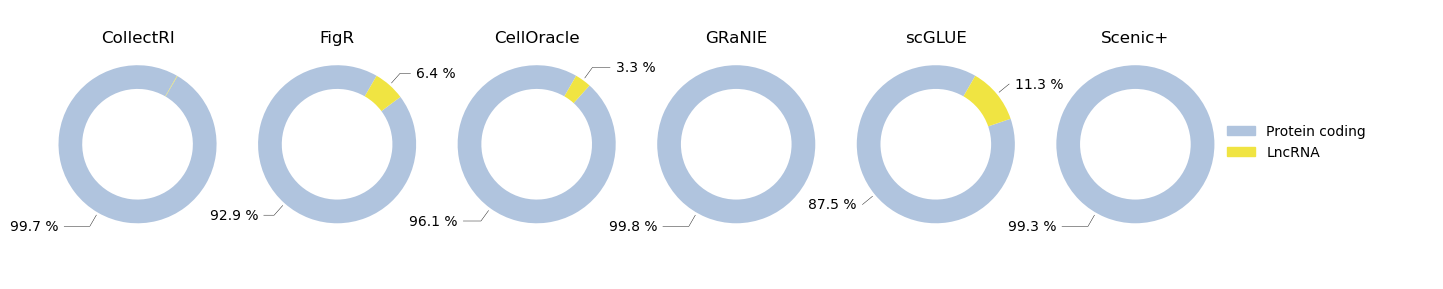

In [704]:
import matplotlib.patches as mpatches

fig, axes = plt.subplots(1, len(gene_annotation_df.index) + 1, figsize=(len(gene_annotation_df.index)*3, 3.5))

colors = plots.colors_cell_type[-1], plots.colors_blind[3]
startangle = 60

theta_offsets = [2 , 2, 2, 2 , 2, 2, 2 , 2, 2]
for i, (ax, idx) in enumerate(zip(axes[:-1], gene_annotation_df.index)):
    ax.set_title(idx, fontsize=12, pad=-.5)
    counts = gene_annotation_df.loc[idx]
    wedges, texts = ax.pie(counts, colors=colors, wedgeprops=dict(width=0.3), startangle=startangle, radius=1)

    bbox_props = dict(fc="w", ec="k", lw=0.7)
    kw = dict(arrowprops=dict(arrowstyle="-", linewidth=0.3), zorder=0, va="center", fontsize=10)

    for j, p in enumerate(wedges):
        if counts[j] == 0:
            continue
        ang = (p.theta2 - p.theta1) / theta_offsets[i] + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        if counts[j] > 1:
            text = f'{counts[j]:.1f} %'
            ax.annotate(text, xy=(x, y), xytext=(1 * np.sign(x), 1.2 * y),
                        horizontalalignment=horizontalalignment, **kw)

# Create a legend in the last subplot
ax = axes[-1]
patches = [mpatches.Patch(color=color, label=name) for color, name in zip(colors, gene_annotation_df.columns)]
leg = ax.legend(handles=patches, bbox_to_anchor=(.72, 0.62), fontsize=10)
leg.get_frame().set_linewidth(0.0)
ax.axis('off')
plt.subplots_adjust(wspace=0.01)  # Adjust horizontal space between subplots

# plt.tight_layout()
# plt.show()
fig.savefig(f'{work_dir}/benchmark/figs/gene_annotation.png', dpi=300, transparent=True, bbox_inches='tight')

## HVGs analysis


In [4]:
bulk_adata = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_integrated.h5ad')

n_hvgs = 3000

In [54]:
hvgs_sce = np.loadtxt( f'{work_dir}/benchmark/hvgs.txt', dtype=str)

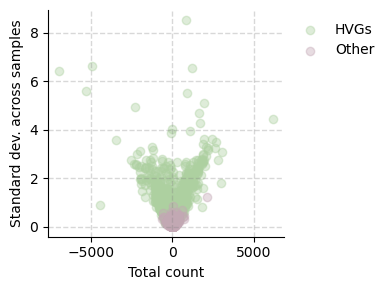

In [350]:
genes = hvgs_sce
bulk_adata.X = bulk_adata.layers['scgen_pearson']
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=False)    
var = bulk_adata.var
var['sum'] = bulk_adata.X.sum(axis=0)
var['std'] = bulk_adata.X.std(axis=0)
mask = var.index.isin(genes)
ax.scatter(var['sum'][mask], var['std'][mask], label='HVGs', alpha=0.4, color='#add0a0')
ax.scatter(var['sum'][~mask], var['std'][~mask], label='Other', alpha=0.4, color='#c4a8b5')


ax.set_ylabel('Standard dev. across samples')
ax.set_xlabel('Total count')
# ax.set_xscale('log')
# ax.set_yscale('log')

ax.grid(alpha=0.3, linestyle='--', linewidth=1, color='grey')

for side in ['right', 'top']:
    ax.spines[side].set_visible(False)

ax.legend(title='', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

plt.tight_layout()
fig.savefig(f'{work_dir}/benchmark/figs/hvgs_sum_std.png', dpi=150, transparent=True)

### GRN targets vs HVGs 

In [371]:
hvgs = hvgs_sce

n_included_hvgs_dict = {}
n_included_hvgs_ratio_dict = {}
pr_dict = {}
for name in grn_models_dict.keys():
    info = info_objs_dict[name].calculate_hvgs_stats()

    n_included_hvgs_dict[name] = round(100*info['n_included_hvgs']/n_hvgs,1)
    n_included_hvgs_ratio_dict[name] = info['ratio']

    pr_dict[name] = info['percentile_rank']

n_included_hvgs_ratio_dict

{'CollectRI': 0.35361216730038025,
 'FigR': 0.3113473999003157,
 'CellOracle': 0.30652304009575104,
 'GRaNIE': 0.28865979381443296,
 'scGLUE': 0.32648343180066786,
 'Scenic+': 0.28259695365669224}

In [372]:
info = calculate_hvgs_stats(housekeeping_genes)
n_included_hvgs_dict['HKGs'] = round(100*info['n_included_hvgs']/n_hvgs,1)
n_included_hvgs_ratio_dict['HKGs'] = info['ratio']

pr_dict['HKGs'] = info['percentile_rank']


In [163]:
pr_dict

{'CollectRI': 0.0,
 'FigR': 0.0,
 'CellOracle': 0.0,
 'GRaNIE': 0.0,
 'scGLUE': 0.0,
 'Scenic+': 0.0}

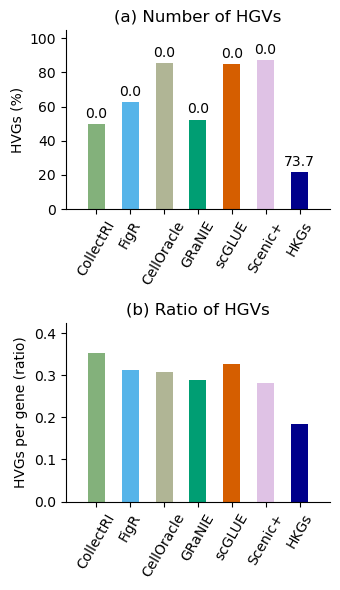

In [713]:
hvgs = hvgs_sce

fig, axes = plt.subplots(2, 1, figsize=(3.5, 6), sharey=False)


def plot_bar(ax, data, y_label, pr_dict=None):
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)
    colors = [COLORS[surragate_names.get(key, key)] for key in data.keys()]
    
    x_range = [x for x in range(len(data))]
    y_values = list(data.values())
    ax.bar(x_range, y_values, width=width, color=colors, label='SCRE')
    ax.set_xticks(x_range)
    ax.set_xticklabels(data.keys())
    ax.tick_params(axis='x', rotation=60)
    ax.margins(x=.1, y=.2)
    ax.set_ylabel(y_label)
    if pr_dict is None:
        return 
    for i_text, value in enumerate(pr_dict.values()):
        # if value < 0.0001:
        #     txt = '***'
        # if value < 0.001:
        #     txt = '**'
        # elif value < 0.01:
        #     txt = '*'
        # else:
        #     txt = ''
        txt = f'{value}'
        ax.text(x_range[i_text], y_values[i_text] + 2, txt, ha='center', va='bottom')


width = .5
ax = axes[0]
plot_bar(ax, n_included_hvgs_dict, y_label='HVGs (%)', pr_dict=pr_dict)
ax.set_title('(a) Number of HGVs')

ax = axes[1]
plot_bar(ax, n_included_hvgs_ratio_dict, y_label='HVGs per gene (ratio)')
ax.set_title('(b) Ratio of HGVs')

# axes[1].legend(loc='upper left', bbox_to_anchor=(1,1), frameon=True)

plt.tight_layout()
fig.savefig(f'{work_dir}/benchmark/figs/hvgs_stats.png', dpi=300, transparent=True)
plt.show()

# Regression 

In [ ]:
norm_method = None

bulk_adata = ad.read('../output/preprocess/bulk_adata_integrated.h5ad')
bulk_index = ['sm_name', 'cell_type', 'donor_id', 'plate_name', 'row']
# data = bulk_adata.layers[f'X_norm_{norm_method}']
# data = bulk_adata.X
data = bulk_adata.layers['seurat']

df_train = pd.DataFrame(data, columns=bulk_adata.var.index, index= pd.MultiIndex.from_frame(bulk_adata.obs[bulk_index]))

df_train.head()


/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


index                                                            A1BG  \
sm_name               cell_type     donor_id plate_name row             
TIE2 Kinase Inhibitor B cells       Donor 1  010        A   -0.456954   
                      Myeloid cells Donor 1  010        A   -0.575009   
                      NK cells      Donor 1  010        A   -0.367954   
                      T cells       Donor 1  010        A    0.665574   
MK-5108               B cells       Donor 1  010        A    1.214316   

index                                                        A1BG-AS1  \
sm_name               cell_type     donor_id plate_name row             
TIE2 Kinase Inhibitor B cells       Donor 1  010        A    0.178955   
                      Myeloid cells Donor 1  010        A    0.106276   
                      NK cells      Donor 1  010        A    1.007036   
                      T cells       Donor 1  010        A    0.382907   
MK-5108               B cells       Donor 1  010        A    2.541742   

index                                                             A2M  \
sm_name               cell_type     donor_id plate_name row             
TIE2 Kinase Inhibitor B cells       Donor 1  010        A   -0.675342   
                      Myeloid cells Donor 1  010        A    1.310987   
                      NK cells      Donor 1  010        A    0.003117   
                      T cells       Donor 1  010        A   -0.564866   
MK-5108               B cells       Donor 1  010        A   -0.675492   

index                                                         A2M-AS1  \
sm_name               cell_type     donor_id plate_name row             
TIE2 Kinase Inhibitor B cells       Donor 1  010        A   -0.672942   
                      Myeloid cells Donor 1  010        A   -0.652688   
                      NK cells      Donor 1  010        A    1.063749   
                      T cells       Donor 1  010        A   -0.452515   
MK-5108               B cells       Donor 1  010        A   -0.668740   

index                                                           A2MP1  \
sm_name               cell_type     donor_id plate_name row             
TIE2 Kinase Inhibitor B cells       Donor 1  010        A   -0.480910   
                      Myeloid cells Donor 1  010        A   -0.480910   
                      NK cells      Donor 1  010        A    1.116476   
                      T cells       Donor 1  010        A   -0.178416   
MK-5108               B cells       Donor 1  010        A   -0.480910   

index                                                            AAAS  \
sm_name               cell_type     donor_id plate_name row             
TIE2 Kinase Inhibitor B cells       Donor 1  010        A    0.037427   
                      Myeloid cells Donor 1  010        A   -0.674204   
                      NK cells      Donor 1  010        A    0.727295   
                      T cells       Donor 1  010        A   -1.417941   
MK-5108               B cells       Donor 1  010        A   -0.964661   

index                                                            AACS  \
sm_name               cell_type     donor_id plate_name row             
TIE2 Kinase Inhibitor B cells       Donor 1  010        A    1.854700   
                      Myeloid cells Donor 1  010        A    0.057568   
                      NK cells      Donor 1  010        A   -0.414309   
                      T cells       Donor 1  010        A   -0.381207   
MK-5108               B cells       Donor 1  010        A    0.874025   

index                                                           AAGAB  \
sm_name               cell_type     donor_id plate_name row             
TIE2 Kinase Inhibitor B cells       Donor 1  010        A   -0.730331   
                      Myeloid cells Donor 1  010        A    1.033481   
                      NK cells      Donor 1  010        A    0.313179   
                      T cells       Donor 1  010   

In [ ]:
cell_type_index = df_train.index.get_level_values('cell_type').astype(str) 

In [ ]:
# grn_model_names = ['figr', 'celloracle', 'granie', 'ananse', 'scglue', 'scenicplus']
grn_model_names = ['celloracle', 'scenicplus']

grn_models_dict = {}
for name in grn_model_names:
    grn_models_dict[name] = pd.read_csv(f'../output/benchmark/grn_models/{name}.csv', index_col=0)

# grn_models_dict = {}
# baselines = ['positive_control', 'negative_control']
baselines = ['positive_control']
for name in baselines:
    grn_models_dict[name] = pd.read_csv(f'../output/benchmark/baseline_models/{name}.csv', index_col=0)


In [ ]:
grn_models_dict.keys()

dict_keys(['positive_control', 'negative_control'])

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
# from skranger.ensemble import RangerForestRegressor
# from sklearn.multioutput import MultiOutputRegressor


class lightgbm_wrapper:
    def __init__(self, params):
        self.params =  params
        
    def fit_predict(self, X_train, Y_train, X_test):
        y_pred_list = []
        for i in range(Y_train.shape[1]):
            regr = 
            regr.fit(X_train, Y_train[:, i])
            y_pred = regr.predict(X_test)
            y_pred_list.append(y_pred)
            
        return np.stack(y_pred_list, axis=1)
    def predict(self)

In [ ]:
class Regression_analysis_GRN_weight:
    ''' Uses GRN weights as feature space to predict perturbation data.
    '''
    def __init__(self, 
            **kwargs) -> None:
        self.run_groups(**kwargs)

    def run_groups(self, df_train:pd.DataFrame,
            net: pd.DataFrame, 
            group_index: str, 
            reg_type: str = 'GB', 
            params: dict = {}, 
            verbose: int = 0
            ) -> None:
        cell_type_index = df_train.index.get_level_values('cell_type')

        self.r2_scores_groups = {}
        n_groups = len(group_index.unique())
        pbar = tqdm.tqdm(group_index.unique(), desc="Group cv")
        for group_i, group in enumerate(pbar):
            # subset df for cell type 
            mask = group_index==group
            df_subset = df_train[mask]

            cell_type = df_subset.index.get_level_values('cell_type').unique()[0]

            # net is cell type dependent or not 
            if 'cell_type' in net:
                net_celltype = net[net.cell_type==cell_type]
            else:
                net_celltype = net.copy()
            # match net and df in terms of shared genes
            grn_net = self.match_data(df_train, net_celltype)

            # pivot to have gene*tf matrix
            grn_net = net_celltype.pivot(index='target', columns='source', values='weight').fillna(0)
            if verbose >=2:
                print(f'X (genes, TFs): {grn_net.shape}, Y (genes, samples): {Y.shape}')
            # fill random weights for the missing genes
            grn_net = self.add_random_weights(df_subset, grn_net)
            
            # get training data
            X = grn_net.values
            Y = df_subset.values.T              
            # run cv 
            self.r2_scores_groups[group] = self.run_cross_validation(X, Y, reg_type)
    def get_results(self) -> dict[str, float]:
        return self.r2_scores_groups

    @staticmethod
    def add_random_weights(df_train, net):
        net_genes = net.index.unique()
        shared_genes = np.intersect1d(net_genes, df_train.columns)
        missing_genes = np.setdiff1d(df_train.columns, shared_genes)
        tfs_n = net.columns.unique().shape[0]
        
        sparsity = (net.values==0).sum()/net.values.size
        ratios = [sparsity, (1-sparsity)/2, (1-sparsity)/2]
        shape = (missing_genes.shape[0], tfs_n)
        X_random = np.random.choice([0, -1, 1], size=shape, p=ratios)
        net = pd.concat([net, pd.DataFrame(X_random, columns=net.columns, index=missing_genes)])
        net = net.reindex(df_train.columns)
        return net
    @staticmethod
    def match_data(df_train: pd.DataFrame, net_celltype: pd.DataFrame) -> pd.DataFrame:
        # match net and df in terms of shared genes 
        net_genes = net_celltype.target.unique()
        shared_genes = np.intersect1d(net_genes, df_train.columns)
        net_celltype = net_celltype[net_celltype.target.isin(shared_genes)]

        return net_celltype
    @staticmethod
    def cv_5(genes_n):
        '''5 fold standard'''
        num_groups = 5
        group_size = genes_n // num_groups
        groups = np.repeat(np.arange(num_groups), group_size)
        if genes_n % num_groups != 0:
            groups = np.concatenate((groups, np.arange(genes_n % num_groups)))
        np.random.shuffle(groups)
        return groups
    @classmethod
    def run_cross_validation(cls, X: np.ndarray, Y: np.ndarray, reg_type: str):
        # determine regressor 
        if reg_type=='ridge':
            regr = MultiOutputRegressor(Ridge(**params))
        else:
            regr = MultiOutputRegressor(lightgbm.LGBMRegressor(**params), n_jobs=10)

        # define cv scheme
        cv_groups = cls.cv_5(X.shape[0])

        Y_pred_stack = []
        Y_true_stack = []
        unique_cv_groups = np.unique(cv_groups)
        
        for cv_group in unique_cv_groups:
            mask_va = cv_groups==cv_group
            mask_tr = ~mask_va

            X_tr, Y_tr = X[mask_tr,:], Y[mask_tr,:]
            X_va, Y_true = X[mask_va,:], Y[mask_va,:]

            regr.fit(X_tr, Y_tr)
            Y_pred = regr.predict(X_va)

            Y_pred_stack.append(Y_pred)
            Y_true_stack.append(Y_true)
        y_pred = np.concatenate(Y_pred_stack, axis=0)
        y_true = np.concatenate(Y_true_stack, axis=0)
        r2_score_group = r2_score(y_true, y_pred, multioutput='variance_weighted') #uniform_average', 'variance_weighted
        return r2_score_group


In [ ]:
reg_type = 'GB'
manipulate = None #'signed', None 'shuffled'


In [ ]:
if True:
    os.makedirs(f'{work_dir}/benchmark/scores/{reg_type}/{norm_method}/', exist_ok=True)

    # grn_model = 'celloracle'
    # net = grn_models_dict[grn_model]

    for i_model, (grn_model, net) in enumerate(grn_models_dict.items()):
        print(grn_model)
        print(f'{i_model+1}/{len(grn_models_dict)} in run')
        # shuffle or 
        if manipulate=='shuffled':
            net = grn_shuffle(net)
        elif manipulate=='signed':
            net = sign_grn(net)
        # print(grn_model)
        if reg_type=='ridge':
            params = dict(random_state=32, alpha = 100) 
        elif reg_type=='rf':
            params = dict(random_state=32, n_estimators=100, boosting_type="rf", n_jobs=10, 
            feature_fraction = 0.8, verbosity=-1 )
            # params = dict(seed =32, n_estimators=100)
        elif reg_type=='GB':
            params = dict(random_state=32, n_estimators=100, min_samples_leaf=2, min_child_samples=1, feature_fraction=0.05, verbosity=-1)

        else:
            raise ValueError('define first')
        obj = Regression_analysis_GRN_weight(df_train=df_train, net=net, group_index=cell_type_index, reg_type=reg_type, params=params, verbose=0)
        output = obj.get_results() 
        with open(f'{work_dir}/benchmark/scores/{reg_type}/{norm_method}/{grn_model}_{manipulate}.json', 'w') as f:
            json.dump(output, f)


celloracle
1/3 in run


Group cv:   0%|          | 0/4 [5:05:01<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
output

{'B cells': -0.01214258258784739,
 'Myeloid cells': -0.00621784775835288,
 'NK cells': -0.014287911579543329,
 'T cells': -0.006072343868746141}

In [ ]:
#scenicplus
output

{'B cells': 0.014848572451914436,
 'Myeloid cells': 0.14944866993126402,
 'NK cells': 0.020442075940622223,
 'T cells': 0.09782135325298896}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


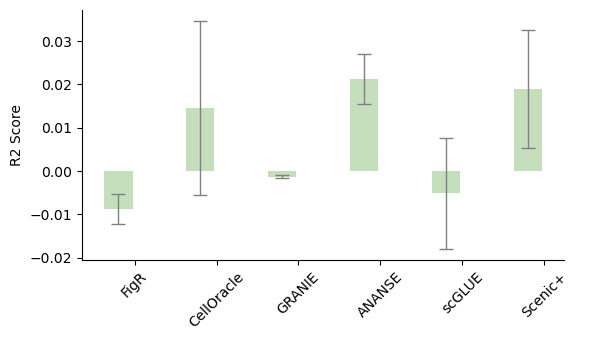

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5)) 

legend_colors = ['#add0a0', '#c4a8b5', 'orange']

offset = .4
width = .35
score_lower_t = -1

handles = []  # To store legend handles
for i_plot, norm_method in enumerate([None]):
    # --- read the scores
    model_names = []
    mean_score_list = []
    scores_all_list = []
    sig_sign_list = []
    # for grn_model in grn_models_dict.keys():
    for grn_model in ['figr', 'celloracle', 'granie', 'ananse', 'scglue', 'scenicplus']:
        file = f'{work_dir}/benchmark/scores/{reg_type}/{norm_method}/{grn_model}_None.json'
        if not os.path.isfile(file):
            print(f'{file} doesnt exist')
            continue
        with open(file, 'r') as f:
            scores_dict = json.load(f)
            scores_all = np.asarray(list(scores_dict.values()))
            mean_score = np.mean(scores_all) #mean_score_r2
        model_names.append(grn_model)
        mean_score_list.append(mean_score)
        scores_all_list.append(scores_all)
    
    # plot 
    x_ticks = range(len(model_names))
    x_positions = [xx + (offset * (i_plot - 0.5)) for xx in x_ticks]
    error_kw = {'ecolor': 'gray', 'capsize': 5, 'capthick': 1, 'elinewidth': 1}

    y_positions = np.mean(scores_all_list, axis=1) 
    std = np.std(scores_all_list, axis=1)
    # norm_method = surragate_names[norm_method]
    ax.bar(x_positions, height=y_positions, yerr=std, capsize=5, alpha=0.7,  width=width, color=legend_colors[i_plot], error_kw=error_kw, label=norm_method)


    ax.set_xticks(x_ticks)
    ax.set_xticklabels([surragate_names[name] for name in model_names], rotation=45)
    ax.set_ylabel('R2 Score')
    # ax.set_ylim([0, .7])

    #-- annotate 
    # for ii, x_pos in enumerate(x_positions):
    #     y_pos = y_positions[ii] + std[ii] + .2 * i_plot
    #     txt = f'{mean_score_list[ii]:.2f}'
    #     ax.text(x_pos, y_pos, txt, ha='center', color='black', fontsize=8)
ax.legend(loc=(1.01,.8), frameon=False)
# # Correcting text annotations with offset adjustments

for side in ['right', 'top']:
    ax.spines[side].set_visible(False)

plt.tight_layout()

fig.savefig(f'{work_dir}/benchmark/figs/r2_scores.png', dpi=150, transparent=True)

plt.show()